## notes
* weird behavior for input frequency in the ranges [978.6, 988.2] and [2303.4, 2313.0] MHz - data is extremely noisy regardless of actual signal
* input can only operate in 1st Nyquist zone (rolls off rapidly above 1.2 GHz) - might be able to change the coarse mixer?


In [1]:
# import sys
# sys.path.append('../qick/qick_lib/')

from mkids_4x1024 import TopSoc
from numpy.fft import fftshift
from scipy.signal import welch
# from scipy.interpolate import interp1d
from tqdm.auto import tqdm

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# Load bitstream with custom overlay
soc = TopSoc('./mkids_4x1024.bit', force_init_clks=True)

resetting clocks: 245.76 491.52


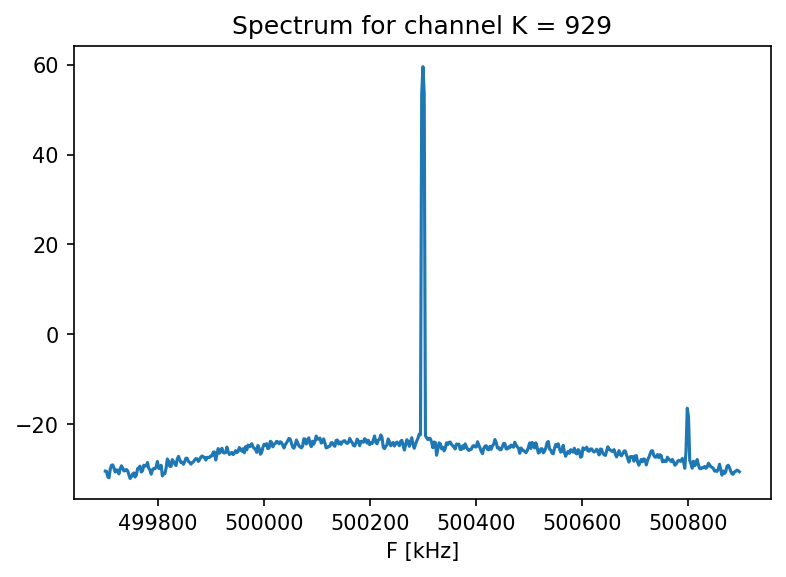

In [3]:
def plot_spectrum(fs, fcenter, K, x_buf):
    x = x_buf.dot([1, 1j])

    plt.figure(1,dpi=150)

    F, Y = fftshift(welch(x,
                          fs*1000,
                          return_onesided=False,
                          detrend=False,
                          nperseg=512), axes=1)
    F += fcenter*1000
    plt.plot(F,10*np.log10(Y)) # welch gives you power spectrum

    plt.title("Spectrum for channel K = %d" %K);
    plt.xlabel("F [kHz]");

soc.set_mixer(1000) # MHz
fout = 500.3
soc.set_outputs([fout], 0.1)
# soc.set_outputs([fout], 0.00004) # minimum power
# soc.set_outputs([fout], -1.0) # maximum power

soc.set_inputs([fout], decimation=2, downconvert=True)

K = soc.input_config['pfb_ch']
fs = soc.input_config['fs']
fcenter = soc.input_config['center_freq']

x_buf = soc.read(average=False)[0]

plot_spectrum(fs, fcenter, K, x_buf)

In [4]:
fmix = 0 # MHz
# fmix = 1000 # MHz
fstart = 498
fstop = 503
# fstart = 998
# fstop = 1003

soc.set_mixer(fmix)
freqs = soc.round_freq(np.linspace(fstart,fstop,201))
results_complex = np.zeros_like(freqs, dtype=complex)
for i, fout in enumerate(tqdm(freqs)):
    results_complex[i] = soc.measure([fout], gain=0.1, equalize=True)[0]


  0%|          | 0/201 [00:00<?, ?it/s]

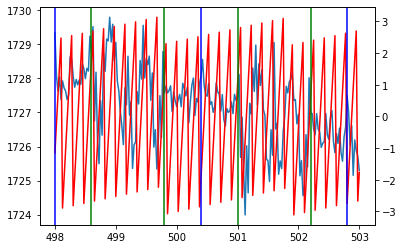

In [5]:
# plot gain+phase with PFB channel boundaries
output_spacing = soc.pfb_out.fc
input_spacing = soc.pfb_in.fc
def edges(start, stop, spacing, offset=0):
    offset_phase = (0.5+offset/spacing)%1
    return spacing * np.arange(start/spacing + ((offset_phase - start/spacing) % 1), stop/spacing)

output_edges = edges(fstart, fstop, output_spacing, fmix%output_spacing)
input_edges = edges(fstart, fstop, input_spacing)

fig, ax1 = plt.subplots()

ax1.plot(freqs, np.abs(results_complex))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, np.angle(results_complex),color='red')

for f in output_edges:
    plt.axvline(f, color='blue')
for f in input_edges:
    plt.axvline(f, color='green')

In [6]:
# adjust the phase calibration to zero out the slope seen in this measurement
soc.calib_phase(freqs, results_complex)

adjusting phase slope by 36.3194 rad/MHz
old value 31.8194 rad/MHz, new value 68.1389 rad/MHz


  0%|          | 0/201 [00:00<?, ?it/s]

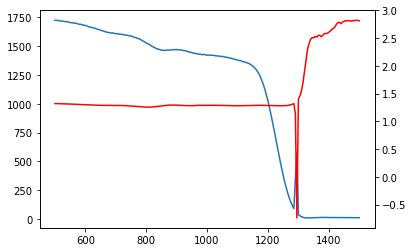

In [7]:
# fmix = 500 # MHz
# fstart = 10
# fstop = 1000
# fmix = 0 # MHz
fmix = 1000 # MHz
fstart = 500
fstop = 1500

soc.set_mixer(fmix)
freqs = soc.round_freq(np.linspace(fstart,fstop,201))
results_complex = np.zeros_like(freqs, dtype=complex)
for i, fout in enumerate(tqdm(freqs)):
    results_complex[i] = soc.measure([fout], gain=0.1)[0]
    
# plt.plot(freqs, np.abs(results_complex))
fig, ax1 = plt.subplots()
ax1.plot(freqs, np.abs(results_complex))

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(freqs, np.angle(results_complex),color='red')

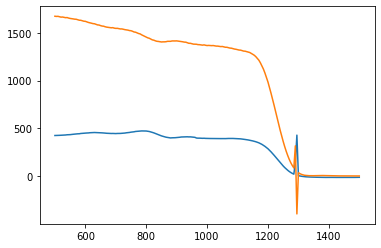

In [8]:
# plot IQ
plt.plot(freqs, np.real(results_complex))
plt.plot(freqs, np.imag(results_complex))

### test streamer - based on demo_02_stream_deadtime by Chris

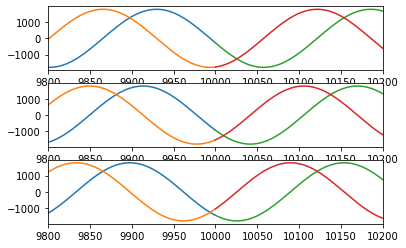

In [10]:
soc.set_mixer(1000) # MHz
fout = 500.3

nOffset = 1
decimation = 128
nt=1

# breaking the stream up into smaller transfers seems to help at lower decimation values
# nOffset = 4
# decimation = 32
# nt=10

soc.set_outputs([fout], 0.1)
fout += nOffset*soc.DF # minimum frequency step
soc.set_inputs([fout], decimation=decimation, downconvert=True)


nsamp = 10000
delta = 200
nreads = 4
data = []
inds = np.arange(nsamp)

#streamer_ch = soc.input_config['streamer_ch']

for i in range(nreads):
    # normally we truncate the first 200 samples, because they are stale values from the previous read.
    data.append(soc.read(average=False, nt=nt, nsamp=nsamp//nt, truncate=False)[0])

fig,ax = plt.subplots(nreads-1,1)

for i in range(nreads-1):
    ax[i].plot(inds, data[i])
    ax[i].plot(inds+nsamp, data[i+1])
    ax[i].set_xlim((nsamp-delta, nsamp+delta))


### basic test of multitone readout
read out a list of tones together and separately

In [16]:
freqs = [500, 600, 502.1, 506.11]
gain = 0.1
print("multitone: %s"%(soc.measure(freqs, gain)))

for i, freq in enumerate(freqs):
    print("tone %d: %s"%(i, soc.measure([freq], gain)))

multitone: [403.8788352 +1681.64261759j 430.78027966+1631.11996155j
 404.22809853+1681.21739849j 403.72533636+1677.83792804j]
tone 0: [408.87876241+1681.36153062j]
tone 1: [437.44366089+1628.1878225j]
tone 2: [412.01089797+1679.91333907j]
tone 3: [412.76273316+1675.71402022j]
